In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load the datasets
oct_df = pd.read_csv('/data/CausalTrial/2019-Oct.csv')  # Update the path to your October dataset
nov_df = pd.read_csv('/data/CausalTrial/2019-Nov.csv')  # Update the path to your November dataset


In [3]:
# Combine the data
data = pd.concat([oct_df, nov_df])

In [4]:
del(oct_df)
del(nov_df)

In [5]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [6]:
# Convert event_time to datetime
data['event_time'] = pd.to_datetime(data['event_time'])


In [7]:
data = data.dropna(how='all')

In [8]:
data = data.reset_index()

In [9]:
data.tail()

,index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
109950738,67501974,2019-11-30 23:59:58+00:00,view,15700137,2053013559733912211,NaN,NaN,277.74,532714000,02b4131c-0112-4231-aafa-ceaa08e77c1b
109950739,67501975,2019-11-30 23:59:58+00:00,view,28719425,2053013565639492569,apparel.shoes,baden,62.81,545223467,734c5eef-0742-4f8b-9d22-48f75b0bc359
109950740,67501976,2019-11-30 23:59:59+00:00,view,1004833,2053013555631882655,electronics.smartphone,samsung,167.03,557794415,6fecf566-ebb0-4e70-a243-cdc13ce044cb
109950741,67501977,2019-11-30 23:59:59+00:00,view,2701706,2053013563911439225,appliances.kitchen.refrigerators,samsung,566.27,531607492,368ddc8b-5db9-40fb-b7ff-b6582a1192c0
109950742,67501978,2019-11-30 23:59:59+00:00,view,1004233,2053013555631882655,electronics.smartphone,apple,1312.52,579969851,90aca71c-ed8a-4670-866a-761ebacb732d


In [10]:
data.shape

(109950743, 10)

In [11]:
data = data[~data.category_code.isna()]

In [12]:
data = data[~data.brand.isna()]

In [13]:
data.isna().sum()

index            0
event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     8
dtype: int64

In [14]:
data = data.reset_index()

In [15]:
data.shape

(68650192, 11)

## Part 2: Analysis by Product ID

In [11]:
# Identify price changes
data['price_change'] = data.groupby('product_id')['price'].diff()

In [13]:
# Filter for products with price changes
price_change_df = data[data['price_change'] != 0].copy()

In [14]:
price_change_df.shape

(777286, 11)

In [16]:
price_change_df['period'] = np.where(price_change_df['event_time'] < price_change_df['event_time'].shift(-1),'Before','After')

In [17]:
# Aggregate event counts by product_id
event_counts_product = price_change_df.groupby(['product_id', 'period', 'event_type']).size().reset_index(name='count')


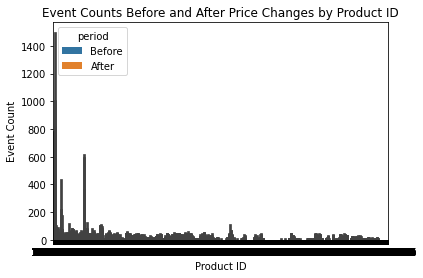

In [18]:
# Plotting by Product ID
sns.barplot(x='product_id', y='count', hue='period', data=event_counts_product)
plt.title('Event Counts Before and After Price Changes by Product ID')
plt.xlabel('Product ID')
plt.ylabel('Event Count')
plt.show()


# Part 3: Analysis by Category Code

In [ ]:
# Aggregate event counts by category_code
event_counts_category = price_change_df.groupby(['category_code', 'period', 'event_type']).size().reset_index(name='count')


In [ ]:
# Plotting by Category Code
sns.barplot(x='category_code', y='count', hue='period', data=event_counts_category)
plt.title('Event Counts Before and After Price Changes by Category Code')
plt.xlabel('Category Code')
plt.ylabel('Event Count')
plt.show()


# Part 4: Conversion Funnel Analysis by Product ID
1.	Calculate Conversion Ratios by Product ID: We'll calculate the view-to-cart and cart-to-purchase ratios for each product_id.


In [16]:
# Filter for relevant event types
conversion_df_product = data[data['event_type'].isin(['view', 'cart', 'purchase'])]


In [17]:
# Calculate conversion ratios by product_id
conversion_ratio_product = conversion_df_product.groupby(['product_id', 'event_type']).size().unstack().fillna(0)
conversion_ratio_product['view_to_cart'] = conversion_ratio_product['cart'] / conversion_ratio_product['view']
conversion_ratio_product['cart_to_purchase'] = conversion_ratio_product['purchase'] / conversion_ratio_product['cart']


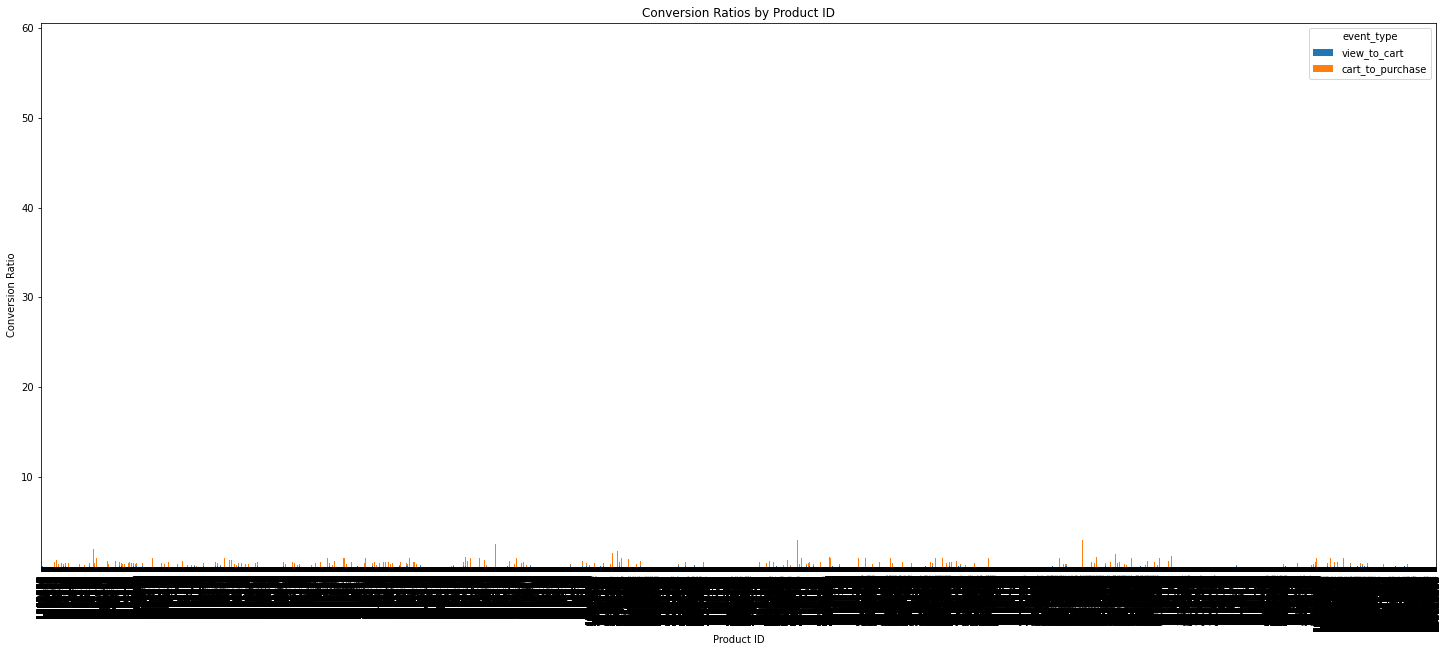

In [24]:
# Plotting Conversion Ratios by Product ID
conversion_ratio_product[['view_to_cart', 'cart_to_purchase']].plot(kind='bar', stacked=True, figsize=(25,10))
plt.title('Conversion Ratios by Product ID')
plt.xlabel('Product ID')
plt.ylabel('Conversion Ratio')
plt.show()


In [32]:
conversion_ratio_product

event_type,cart,purchase,view,view_to_cart,cart_to_purchase
product_id,,,,,
1000365,0.0,0.0,1.0,0.000000,NaN
1000978,60.0,32.0,10342.0,0.005802,0.533333
1001588,16.0,18.0,3979.0,0.004021,1.125000
1001606,0.0,0.0,31.0,0.000000,NaN
1001618,61.0,33.0,1331.0,0.045830,0.540984
...,...,...,...,...,...
100028296,0.0,0.0,1.0,0.000000,NaN
100028349,0.0,0.0,1.0,0.000000,NaN
100028351,0.0,0.0,1.0,0.000000,NaN


In [33]:
conversion_ratio_product.to_csv('Chapter4_conersionbyProduct.csv', index=None)

# Part 5: Conversion Funnel Analysis by Category Code

In [19]:
# Calculate conversion ratios by category_code
conversion_ratio_category = conversion_df_product.groupby(['category_code', 'event_type']).size().unstack().fillna(0)
conversion_ratio_category['view_to_cart'] = conversion_ratio_category['cart'] / conversion_ratio_category['view']
conversion_ratio_category['cart_to_purchase'] = conversion_ratio_category['purchase'] / conversion_ratio_category['cart']


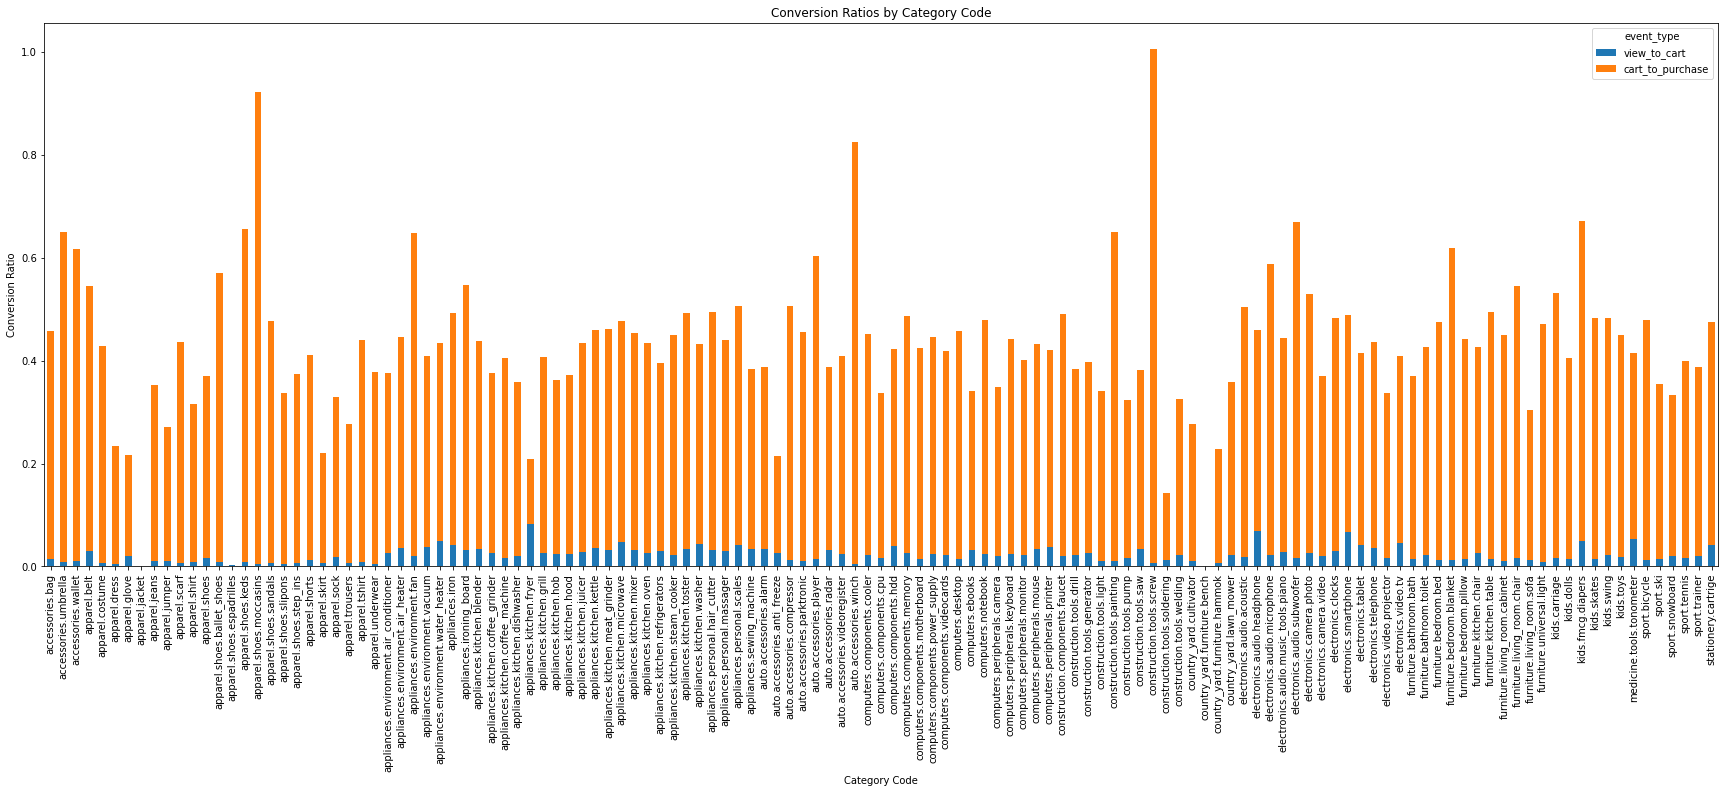

In [23]:
# Plotting Conversion Ratios by Category Code
conversion_ratio_category[['view_to_cart', 'cart_to_purchase']].plot(kind='bar', stacked=True, figsize=(30,10))
plt.title('Conversion Ratios by Category Code')
plt.xlabel('Category Code')
plt.ylabel('Conversion Ratio')
plt.show()


In [31]:
conversion_ratio_category.to_csv('chapter4_ratiobycategory_1.csv', index=None)

## 3. Time-Series Analysis
Temporal Patterns:

In [ ]:
# Group by date and event_type
data['event_date'] = data['event_time'].dt.date
time_series = data.groupby(['event_date', 'event_type']).size().unstack().fillna(0)

In [ ]:
# Plotting
time_series.plot()
plt.title('Temporal Patterns of Events')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.show()


## 4. Causal Inference Modeling
Difference-in-Differences (DiD):


In [ ]:
# Simplified DiD for visualization
# Assuming 'price_change' column is already calculated
did_df = data[data['price_change'] != 0].copy()
did_df['period'] = np.where(did_df['event_time'] < did_df['event_time'].shift(-1), 'Before', 'After')

In [ ]:
# Aggregate and calculate difference-in-differences
did_summary = did_df.groupby(['period', 'event_type']).size().unstack().diff().iloc[-1]

In [ ]:
# Plotting
did_summary.plot(kind='bar')
plt.title('Difference-in-Differences Analysis')
plt.xlabel('Event Type')
plt.ylabel('Difference')
plt.show()

## 5. Customer Behavior Analysis
Repeat Purchases:

In [ ]:
# Identify repeat purchases by user
repeat_df = data[data['event_type'] == 'purchase'].groupby(['user_id', 'product_id']).size().reset_index(name='purchase_count')

In [ ]:
# Filter for repeat purchases
repeat_df = repeat_df[repeat_df['purchase_count'] > 1]

In [ ]:
# Plotting
sns.histplot(repeat_df['purchase_count'], kde=False, bins=10)
plt.title('Distribution of Repeat Purchases')
plt.xlabel('Number of Purchases')
plt.ylabel('Frequency')
plt.show()

## 6. Segmentation Analysis
Brand and Category Impact:

In [ ]:
# Group by brand and category_code
segmentation_df = data.groupby(['brand', 'category_code', 'event_type']).size().unstack().fillna(0)

In [ ]:
# Plotting
segmentation_df.plot(kind='bar', stacked=True)
plt.title('Event Distribution by Brand and Category')
plt.xlabel('Brand - Category Code')
plt.ylabel('Event Count')
plt.show()

## 7. Revenue and Profitability Analysis
Revenue Impact:

In [ ]:
# Calculate total revenue before and after price changes
data['revenue'] = data['price'] * np.where(data['event_type'] == 'purchase', 1, 0)
revenue_df = data.groupby(['product_id', 'period']).agg({'revenue': 'sum'}).unstack()

In [ ]:
# Plotting
revenue_df.plot(kind='bar', stacked=True)
plt.title('Revenue Before and After Price Changes')
plt.xlabel('Product ID')
plt.ylabel('Total Revenue')
plt.show()


## 8. User Cohort Analysis
Cohort Performance:

In [25]:
# Create cohorts based on user session start time
data['cohort'] = data.groupby('user_session')['event_time'].transform('min').dt.to_period('M')

/libraries/Default_env_69876/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [27]:
# Aggregate by cohort and event type
cohort_df = data.groupby(['cohort', 'event_type']).size().unstack().fillna(0)

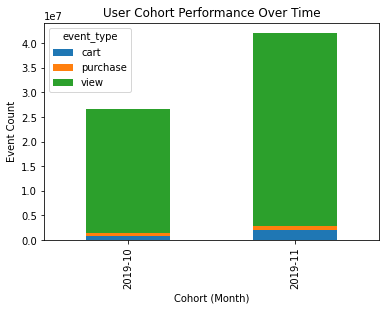

In [28]:
# Plotting
cohort_df.plot(kind='bar', stacked=True)
plt.title('User Cohort Performance Over Time')
plt.xlabel('Cohort (Month)')
plt.ylabel('Event Count')
plt.show()

In [29]:
cohort_df

event_type,cart,purchase,view
cohort,,,
2019-10,809519,549614,25209573
2019-11,2114970,659149,39307359
